<a href="https://colab.research.google.com/github/rfahrn/Shared_Task/blob/main/Shared_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [132]:
import random
import time
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import csv
import emoji
import unicodedata
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pyarabic.araby as ar

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import SparseAdam, Adam

from transformers import AutoTokenizer, AutoModel
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel

In [133]:
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/326k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

No GPU available, using the CPU instead.


,id,tweet,subtask_a
0,1,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,NOT
1,2,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT
2,3,RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...,OFF
3,4,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,NOT
4,5,يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼,NOT
5,6,@USER اخخ يا قلببي يا هالحلقه 😩😭♥️ متعه على بك...,NOT
6,7,والله الزول السوداني أثبت أنه سابق بالتحضّر عن...,NOT
7,8,"RT @USER: جالس أسمع أحمد قاسم يغني: ""أحبك من ك...",NOT
8,9,في قلبي يا مغلاك<LF>وبعيني يا محلاك ..,NOT
9,10,يا التاج ع الراس يا السادة<LF>يا مالك الروح ور...,NOT


In [154]:
train = pd.read_csv('./data/offenseval-ar-training-v1.tsv', sep='\t')

### Preview data

/Users/Jessie/Downloads/UZH/text_mining/Assignments/ex_05/Shared_Task/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'count NOT/OFF')

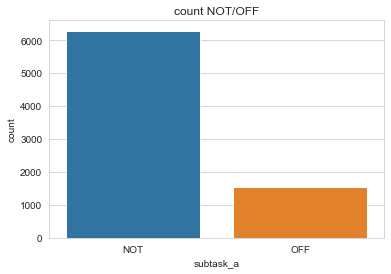

In [141]:
sns.countplot(train.subtask_a)
plt.title('count NOT/OFF')

We can see that there are much more non-offensive than offensive tweets - a common issue in HSD data. Transformers tend to perform better with balanced datasets.

# Text Preprocessing

In [155]:
PUNCTUATION = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''


def remove_emoji(tweet):
    return emoji.get_emoji_regexp().sub(u'', tweet)


def remove_lf(tweet):
    """ This string appears in many tweets and appears to serve no linguistic function """
    return tweet.replace('<LF>', ' ')


def remove_repeat_chars(tweet):
    """ Removes only non-digit, non-punctuation characters that are repeated more than once, since double characters can appear in correct spelling """
    new = ''

    for char in tweet:
        if char.isdigit():
            new += char
        elif char in PUNCTUATION:
            new += char
        else:
            if not new.endswith(char+char):
                new += char

    return new


def remove_diacritics(tweet):
    """ Diacritics in Arabic serve no semantic or syntactic function """
    tweet = ar.strip_tashkeel(tweet)
    tweet = ar.strip_tatweel(tweet)

    tweet = tweet.replace("آ", "ا")
    tweet = tweet.replace("إ", "ا")
    tweet = tweet.replace("أ", "ا")
    tweet = tweet.replace("ؤ", "و")
    tweet = tweet.replace("ئ", "ي")

    return tweet


def normalise_encoding(tweet):
    tweet = re.sub(r'&amp;', '&', tweet)
    tweet = unicodedata.normalize('NFC', tweet)
    return tweet


train['tweet'] = train['tweet'].apply(remove_lf)
train['tweet'] = train['tweet'].apply(remove_repeat_chars)
train['tweet'] = train['tweet'].apply(remove_diacritics)
train['tweet'] = train['tweet'].apply(normalise_encoding)
# Convert to binary values
train['subtask_a'] = train['subtask_a'].apply(lambda x: 1 if x=='OFF' else 0)

# Make one df with emoji and one without to compare performance later
train_no_emoji = train
train_no_emoji['tweet'] = train_no_emoji['tweet'].apply(remove_emoji)

dfs = [train, train_no_emoji]

train.head(10)

/var/folders/vb/9rxy0nsn1sz0zd7f5_x0rkyr0000gp/T/ipykernel_85766/857312938.py:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return emoji.get_emoji_regexp().sub(u'', tweet)


,id,tweet,subtask_a
0,1,الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...,0
1,2,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,0
2,3,RT @USER: يا رب يا واحد يا احد بحق يوم الاحد ا...,1
3,4,RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...,0
4,5,يا بكون بحياتك الاهم يا اما ما بدي اكون,0
5,6,@USER اخخ يا قلببي يا هالحلقه متعه على بكاء ع...,0
6,7,والله الزول السوداني اثبت انه سابق بالتحضر عن ...,0
7,8,"RT @USER: جالس اسمع احمد قاسم يغني: ""احبك من ك...",0
8,9,في قلبي يا مغلاك وبعيني يا محلاك ..,0
9,10,يا التاج ع الراس يا السادة يا مالك الروح وراعيها,0


### Sanity check

In [156]:
def count_chars(tweet):
    return len(tweet)


for df in dfs:
    df['char_count'] = df['tweet'].apply(count_chars)

train_no_emoji.sort_values(by='char_count', ascending=[0]).head(10)

,id,tweet,subtask_a,char_count
2922,2946,من المظاهر الموسفه ان الاب والام يقعدون يتها...,0,5519
6062,6160,جده الحب ،، جده يا منتهى كل الكلام يا سيدة كل...,0,5198
4761,4833,"يا مالي عمري رضا يا شبيه الورد , يا معنى الحي...",0,2974
6564,6707,يا من اظهر الجميل.. وستر القبيح.. يا من لا يوا...,0,2182
2753,2760,يا مكعب السكر يا زمردي الاحمر و ياسري الاكبر ...,0,2043
2124,2125,اللهم اني اسالك مسالة البايس الفقير وادعوك دع...,1,1065
2434,2441,يا سيادة الرييس يا سيادة الرييس نعلم ان الحرب ...,1,284
1399,1400,يا مرحبا ترحيبة عقاب يا نوت والحي يلحق لو تحده...,0,284
3050,3122,انت وامثالك وحكامك وعلمايك الزنادقه خنازير دمر...,1,283
7196,7358,يا عيباه يا حسافاه اليمني بيهان بكل مكان وهذا ...,0,283


Something is weird with these 6 tweets that have 1000+ characters. Those with 281-284 might be explained by my replacing '\<LF\>' with a space to keep word boundaries intact, but 1000+ is clearly some kind of data reading error. I'll just remove them.

In [157]:
for df in dfs:
    df.drop(df[df['char_count'] > 1000].index, inplace=True)
    df.reset_index(drop=True, inplace=True)

train.sort_values(by='char_count', ascending=[0]).head(10)

,id,tweet,subtask_a,char_count
2433,2441,يا سيادة الرييس يا سيادة الرييس نعلم ان الحرب ...,1,284
1399,1400,يا مرحبا ترحيبة عقاب يا نوت والحي يلحق لو تحده...,0,284
7190,7358,يا عيباه يا حسافاه اليمني بيهان بكل مكان وهذا ...,0,283
3047,3122,انت وامثالك وحكامك وعلمايك الزنادقه خنازير دمر...,1,283
6359,6507,بذلة عسكرية وسط الزحام .. حياة مليية بالاشواك ...,0,282
7612,7780,القيناوية غاليين عليا اشرفها مية مية يا خلق يا...,0,282
2653,2661,الهلال امانة في يديكم حنا عند الله ثم عندكم قب...,0,282
6727,6895,يا امعه يا مغفل تجيب تغريدات مشجعين مراهقين؟ ...,1,282
7734,7902,#قروب_المشتاقون_للجنه #عبدالرحمن_الخشتي اللهم ...,0,282
475,476,الرساله فيها عشم مش طبيعي بس مش مشكلتي. اولا ك...,1,282


# BERT Preprocessing

In [159]:
MAX_LEN = 284

def preprocessing_for_bert(data, version="mini"):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-mini-arabic") if version == "mini" else AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

    # For every sentence...
    for i, sent in enumerate(data):
        encoded_sent = tokenizer.encode_plus(
            text = sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            padding='max_length',           # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,     # Return attention mask
            truncation = True
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

## Train-test split

In [ ]:
def tt_split(df):
    items, labels = df['tweet'], df['subtask_a']
    train_items, test_items, train_labels, test_labels = train_test_split(items, labels, test_size=.15, random_state=42)

    train_items = train_items.tolist()
    train_labels = train_labels.to_numpy()
    test_items = test_items.tolist()
    test_labels = test_labels.to_numpy()

    return train_items, train_labels, test_items, test_labels


data_with_emoji = {}
data_without_emoji = {}

data_with_emoji['train items'], data_with_emoji['train labels'], data_with_emoji['test items'], data_with_emoji['test labels'] \
    = tt_split(train)
data_without_emoji['train items'], data_without_emoji['train labels'], data_without_emoji['test items'], data_without_emoji['test labels'] \
    = tt_split(train_no_emoji)

In [161]:
dicts = [data_with_emoji, data_without_emoji]

# Run function `preprocessing_for_bert` on the train and test sets and convert label types to torch.Tensor
for d in dicts:
    d['train input ids'], d['train masks'] = preprocessing_for_bert(d['train items'])
    d['test inputs ids'], d['test masks'] = preprocessing_for_bert(d['test items'])

    d['train labels'] = torch.tensor(d['train labels'])
    d['test labels'] = torch.tensor(d['test labels'])

tensor([[    2, 15779,    36,  ...,     0,     0,     0],
        [    2,  4127,  6088,  ...,     0,     0,     0],
        [    2, 15779,    36,  ...,     0,     0,     0],
        ...,
        [    2,    36,  8113,  ...,     0,     0,     0],
        [    2,    36,  8113,  ...,     0,     0,     0],
        [    2,     7,  5132,  ...,     0,     0,     0]])

In [32]:
# removing emojis 
def remove_emoji(string):
    return emoji.get_emoji_regexp().sub(u'', string)

# removing USER
def user_remove(string):
  string = re.sub('(USER)', '', string)
  return string
train['tweet'] = train['tweet'].apply(remove_emoji)
train['tweet'] = train['tweet'].apply(user_remove)
train.head(40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  This is separate from the ipykernel package so we can avoid doing imports until


,id,tweet,subtask_a,word_count,char_count,avg_char_per_word,stopwords,emoji_count
2922,2946,LFمن المظاهر المءسفه ان الاب والام LFيقعدون يت...,NOT,941,5857,4.403137,211,74
6062,6160,LFجده الحب LFجده منتهي الكلام سيده المدن URL ...,NOT,862,5416,4.437751,203,36
4761,4833,مالي عمري رضا شبيه الورد معني الحياه NOT 4834 ...,NOT,531,3178,4.226974,147,108
6564,6707,اظهر الجميل وستر القبيح يءاخذ بالجريره يهتك ال...,NOT,367,2283,4.397163,102,8
2753,2760,مكعب السكر زمردي الاحمر ياسري الاكبر فتنتي الع...,NOT,363,2129,4.165049,79,34
2124,2125,اللهم اني اسالك مساله الباءس الفقير وادعوك دعا...,OFF,179,1113,4.673469,36,3
5316,5414,رنا رنا رنا رنا رنا رنا رنا رنا رنا رنا رنا رن...,NOT,84,279,2.333333,56,0
6428,6571,باي باي باي باي باي باي باي باي باي باي باي با...,NOT,78,272,2.500000,39,0
4030,4102,فهد باص فهد باص فهد باص فهد باص فهد باص فهد با...,OFF,74,276,2.743243,24,0
3777,3849,رب اتسفه رب اتسفه رب اتسفه رب اتسفه رب اتسفه ر...,NOT,73,278,2.821918,36,0


In [ ]:

from sklearn.model_selection import train_test_split
data = train
X = data.tweet.values
y = data.subtask_a.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)
